## Project Eclipse data on the Planetary Computer

The [Project Eclipse Network](https://planetarycomputer.microsoft.com/dataset/eclipse) is a low-cost air quality sensing network for cities and a research project led by the Urban Innovation Group at Microsoft Research.

### Using the STAC API

Project Eclipse data are distributed as a set of parquet files -- one per week. We can use the STAC API to search for files for a specific week.

In [1]:
import pystac_client
import planetary_computer

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace    
)
search = catalog.search(collections=["eclipse"], datetime="2022-03-01")
items = search.get_all_items()
print(f"Found {len(items)} item")
item = items[0]
item

Found 1 item


<Item id=Chicago-2022-02-27>

We'll load the parquet file with pandas.

In [2]:
import geopandas
import pandas as pd

asset = item.assets["data"]
df = pd.read_parquet(
    asset.href, storage_options=asset.extra_fields["table:storage_options"]
)
df

,City,DeviceId,LocationName,Latitude,Longitude,ReadingDateTimeUTC,PM25,CalibratedPM25,Humidity,O3,NO2,CO,BatteryLevel,PercentBattery,CellSignal
0,Chicago,2002,State & Garfield (SB),41.794921,-87.625857,2022-02-27 00:04:04,9.126071,10.39,59.703064,37.728996,142.770187,0.105193,4.143906,91.634804,-83.0
1,Chicago,2002,State & Garfield (SB),41.794921,-87.625857,2022-02-27 00:09:14,10.927937,11.60,60.223389,40.901974,142.898773,0.114015,4.142812,91.634804,-80.0
2,Chicago,2002,State & Garfield (SB),41.794921,-87.625857,2022-02-27 00:14:24,10.395282,11.01,60.884094,33.247395,137.301682,0.096386,4.141094,91.634804,-82.0
3,Chicago,2002,State & Garfield (SB),41.794921,-87.625857,2022-02-27 00:19:33,9.431242,10.61,61.984253,37.036892,130.622101,0.119355,4.142969,91.385475,-81.0
4,Chicago,2002,State & Garfield (SB),41.794921,-87.625857,2022-02-27 00:24:44,9.648221,10.79,62.377930,36.423344,149.283890,0.125682,4.142344,91.385475,-82.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195436,Chicago,2212,EPA Springfield Pump Station E,41.912739,-87.722673,2022-03-05 23:34:33,12.480565,14.46,55.670166,40.417656,96.079803,0.252798,4.156719,87.191406,-86.0
195437,Chicago,2212,EPA Springfield Pump Station E,41.912739,-87.722673,2022-03-05 23:39:43,10.866013,13.39,55.938721,44.407310,96.909615,0.249360,4.156719,87.191406,-86.0
195438,Chicago,2212,EPA Springfield Pump Station E,41.912739,-87.722673,2022-03-05 23:44:53,12.153159,14.26,56.143188,37.700886,101.764137,0.254816,4.157187,87.074219,-86.0
195439,Chicago,2212,EPA Springfield Pump Station E,41.912739,-87.722673,2022-03-05 23:50:03,15.439072,16.17,56.408691,28.147001,97.074806,0.242335,4.155937,87.074219,-85.0


In [3]:
df = df[(df.Longitude > -89) & (df.Longitude < -86)]
len(df)

195441

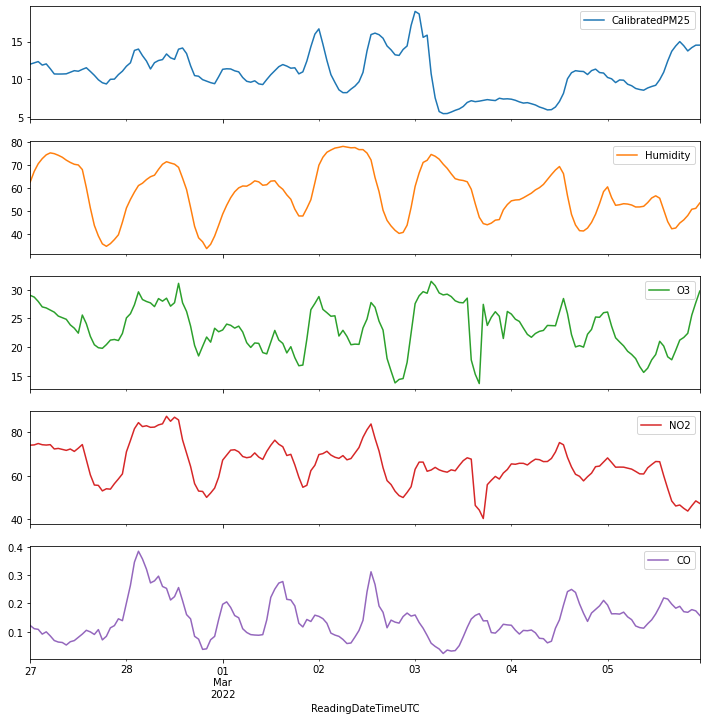

In [4]:
ts = df.resample("H", on="ReadingDateTimeUTC")[
    ["CalibratedPM25", "Humidity", "O3", "NO2", "CO"]
].mean()
ts.plot(subplots=True, sharex=True, figsize=(12, 12));

The dataset contains many observations from each sensor. We can plot the location of each sensor with geopandas, by selecting just the first observation for that sensor.

In [5]:
gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.Longitude, df.Latitude), crs="epsg:4326"
)


gdf[["LocationName", "geometry"]].drop_duplicates(
    subset="LocationName"
).dropna().explore(marker_kwds=dict(radius=8))

Using a [named aggregation](https://pandas.pydata.org/docs/user_guide/groupby.html#named-aggregation) we can compute a summary per senor and plot it on a map. Hover over the markers to see the average Calibrated PM 25 per sensor.

In [6]:
average_pm25 = geopandas.GeoDataFrame(
    gdf.groupby("LocationName").agg(
        mean_pm25=("CalibratedPM25", "mean"), geometry=("geometry", "first")
    ),
    crs="epsg:4326",
)
average_pm25.explore(
    marker_kwds=dict(radius=10),
)

### Reading the full dataset

The STAC collection includes a `data` asset, which links to the root of the parquet dataset. This can be used to read all of the data across time. We'll use [Dask](https://docs.dask.org/) to read in the dataset.

In [7]:
eclipse = catalog.get_collection("eclipse")
asset = planetary_computer.sign(eclipse.assets["data"])

In [8]:
import dask.dataframe as dd

ddf = dd.read_parquet(
    asset.href, storage_options=asset.extra_fields["table:storage_options"]
)
ddf

,City,DeviceId,LocationName,Latitude,Longitude,ReadingDateTimeUTC,PM25,CalibratedPM25,Humidity,O3,NO2,CO,BatteryLevel,PercentBattery,CellSignal
npartitions=58,,,,,,,,,,,,,,,
,object,int32,object,float64,float64,datetime64[ns],float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
